In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load data
df = pd.read_csv('/Users/kun/Desktop/DPF_A3/archive/Google_Stock_Price_Train.csv')

# Preprocess the features and target
df['Close'] = df['Close'].str.replace(',', '')
df['Volume'] = df['Volume'].str.replace(',', '')
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
df['Date'] = pd.to_datetime(df['Date'])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Volume  1258 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 59.1 KB


In [19]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,7380500.0
1,2012-01-04,331.27,333.87,329.08,666.45,5749400.0
2,2012-01-05,329.83,330.75,326.89,657.21,6590300.0
3,2012-01-06,328.34,328.77,323.68,648.24,5405900.0
4,2012-01-09,322.04,322.29,309.46,620.76,11688800.0


In [20]:
df.tail()

,Date,Open,High,Low,Close,Volume
1253,2016-12-23,790.90,792.74,787.28,789.91,623400.0
1254,2016-12-27,790.68,797.86,787.66,791.55,789100.0
1255,2016-12-28,793.70,794.23,783.20,785.05,1153800.0
1256,2016-12-29,783.33,785.93,778.92,782.79,744300.0
1257,2016-12-30,782.75,782.78,770.41,771.82,1770000.0


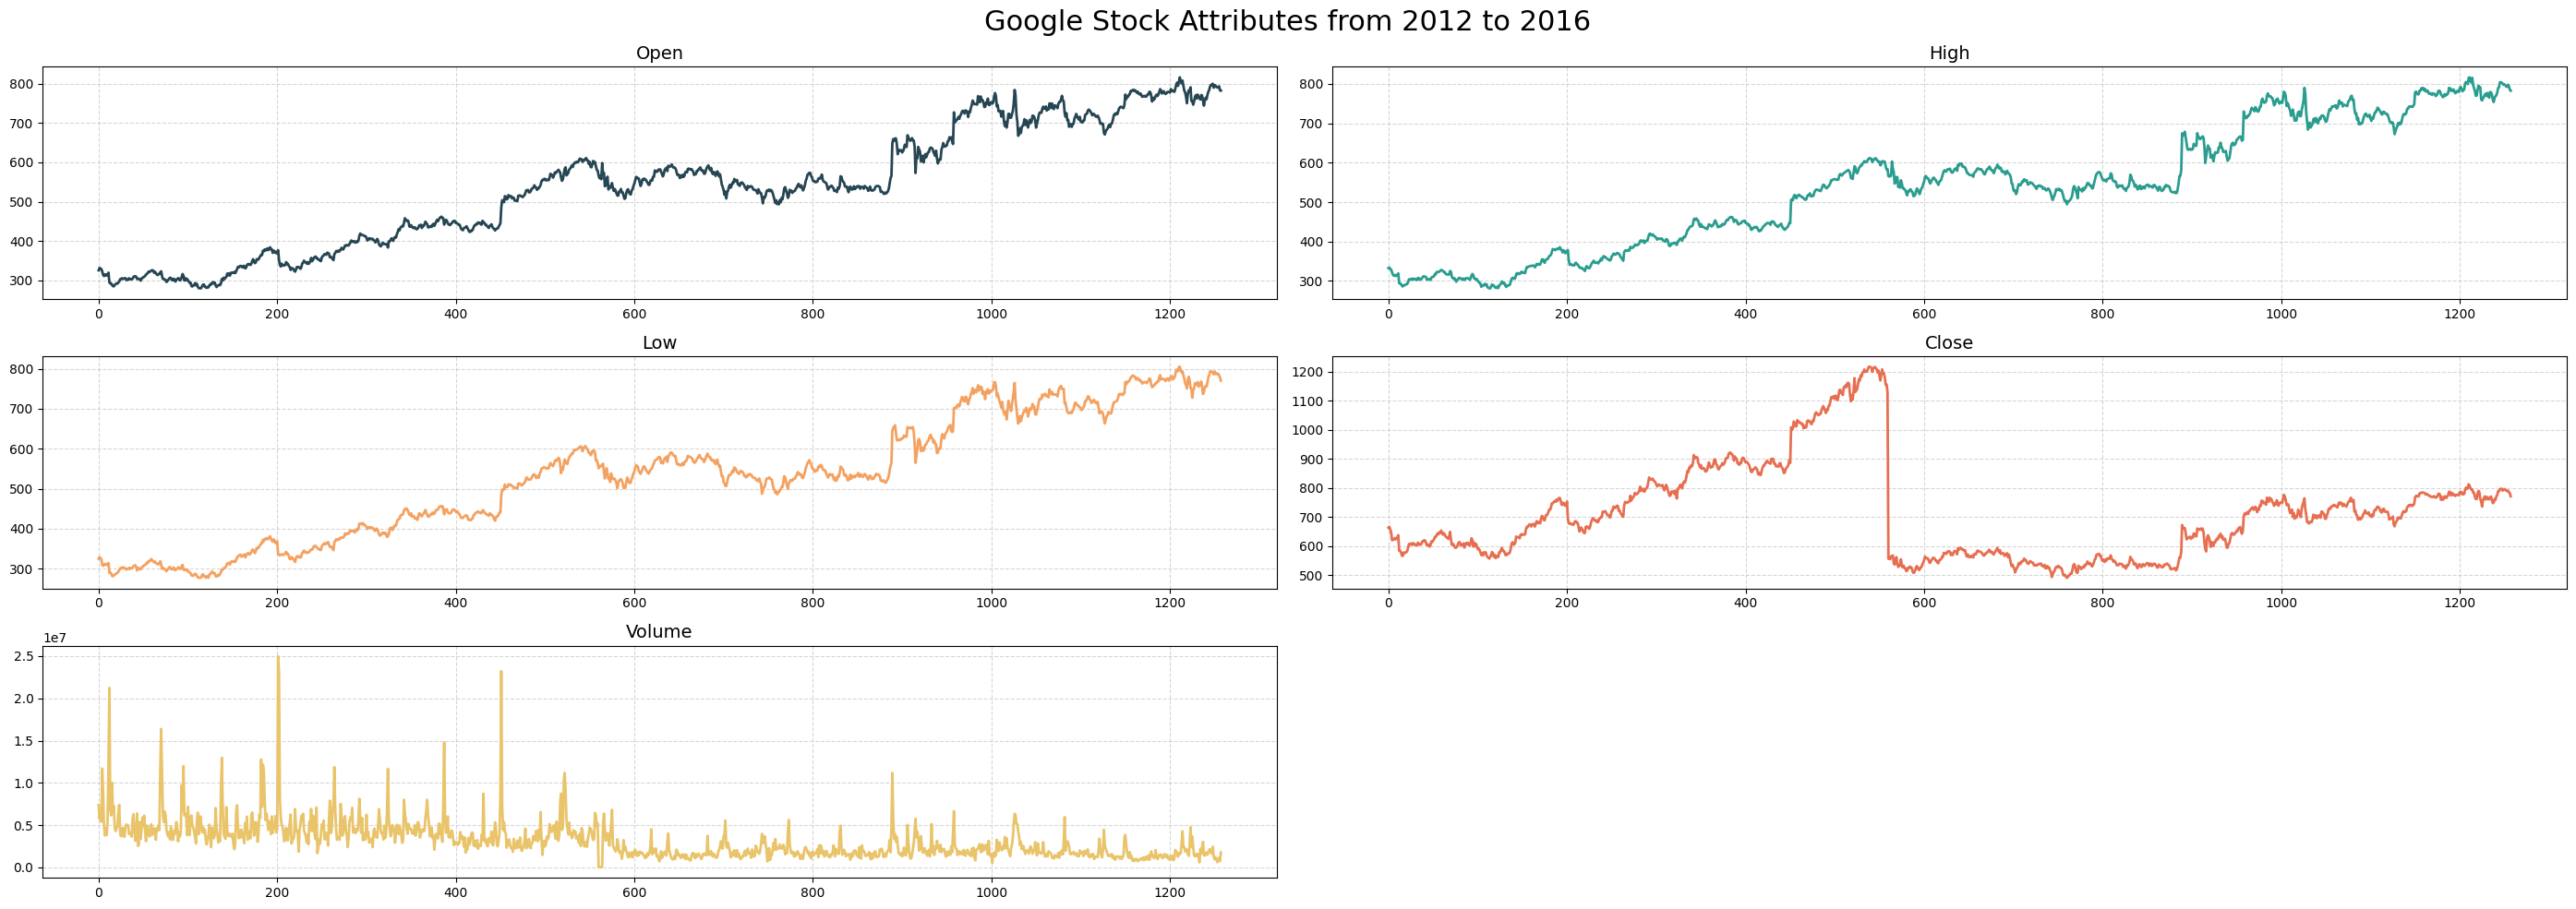

In [21]:
x=df.index
colors = ['#264653', '#2a9d8f', '#f4a261', '#e76f51','#e9c46a']
plt.figure(figsize=(28, 10))
plt.subplot(3, 2, 1)
plt.plot(x, df['Open'], color=colors[0], linewidth=2)
plt.title('Open', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 2)
plt.plot(x, df['High'], color=colors[1], linewidth=2)
plt.title('High', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 3)
plt.plot(x, df['Low'], color=colors[2], linewidth=2)
plt.title('Low', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 4)
plt.plot(x, df['Close'], color=colors[3], linewidth=2)
plt.title('Close', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 5)
plt.plot(x, df['Volume'], color=colors[4], linewidth=2)
plt.title('Volume', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Google Stock Attributes from 2012 to 2016', fontsize=22, y=0.98)
plt.tight_layout()
plt.show()

In [ ]:
features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
target = df['Close'].shift(-1).dropna().values  # Predict next day's Close price
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [ ]:
# Function to create time series data
def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])  # Use past `time_step` days for prediction
        y.append(data[i, 3])  # The target is 'Close' (index 3)
    return np.array(X), np.array(y)

# Create datasets
time_step = 30  # Use past 30 days data to predict the next day's close price
X, y = create_dataset(scaled_features)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape X to be 3D for RNN input: [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])

In [ ]:
# Define RNN model
def build_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(SimpleRNN(units=100, return_sequences=True))
    model.add(SimpleRNN(units=100))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# Train RNN model
rnn_model = build_rnn_model()
rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.7707 - val_loss: 0.0085
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0143 - val_loss: 8.2851e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0041 - val_loss: 8.5925e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0038 - val_loss: 8.2281e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0045 - val_loss: 8.5938e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0028 - val_loss: 7.6013e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019 - val_loss: 9.2603e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/ste

In [ ]:
# Define LSTM model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(LSTM(units=100))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# Train LSTM model
lstm_model = build_lstm_model()
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0545 - val_loss: 0.0030
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0138 - val_loss: 0.0016
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0076 - val_loss: 0.0014
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0096 - val_loss: 6.7447e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0043 - val_loss: 0.0011
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0052 - val_loss: 0.0017
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0023 - val_loss: 6.6442e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0055 - val_loss: 5.6060e-04
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

In [14]:
# Define GRU model
def build_gru_model():
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(GRU(units=100, return_sequences=True))
    model.add(GRU(units=100))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# Train GRU model
gru_model = build_gru_model()
gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0344 - val_loss: 4.5035e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0017 - val_loss: 6.5132e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0027 - val_loss: 6.9155e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0025 - val_loss: 2.8275e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0011 - val_loss: 7.5493e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0020 - val_loss: 2.8652e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0018 - val_loss: 2.5673e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 8.7170e-04 - val_loss: 1.9113e-04
Epoch 12/50
31/31 ━━━━━━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


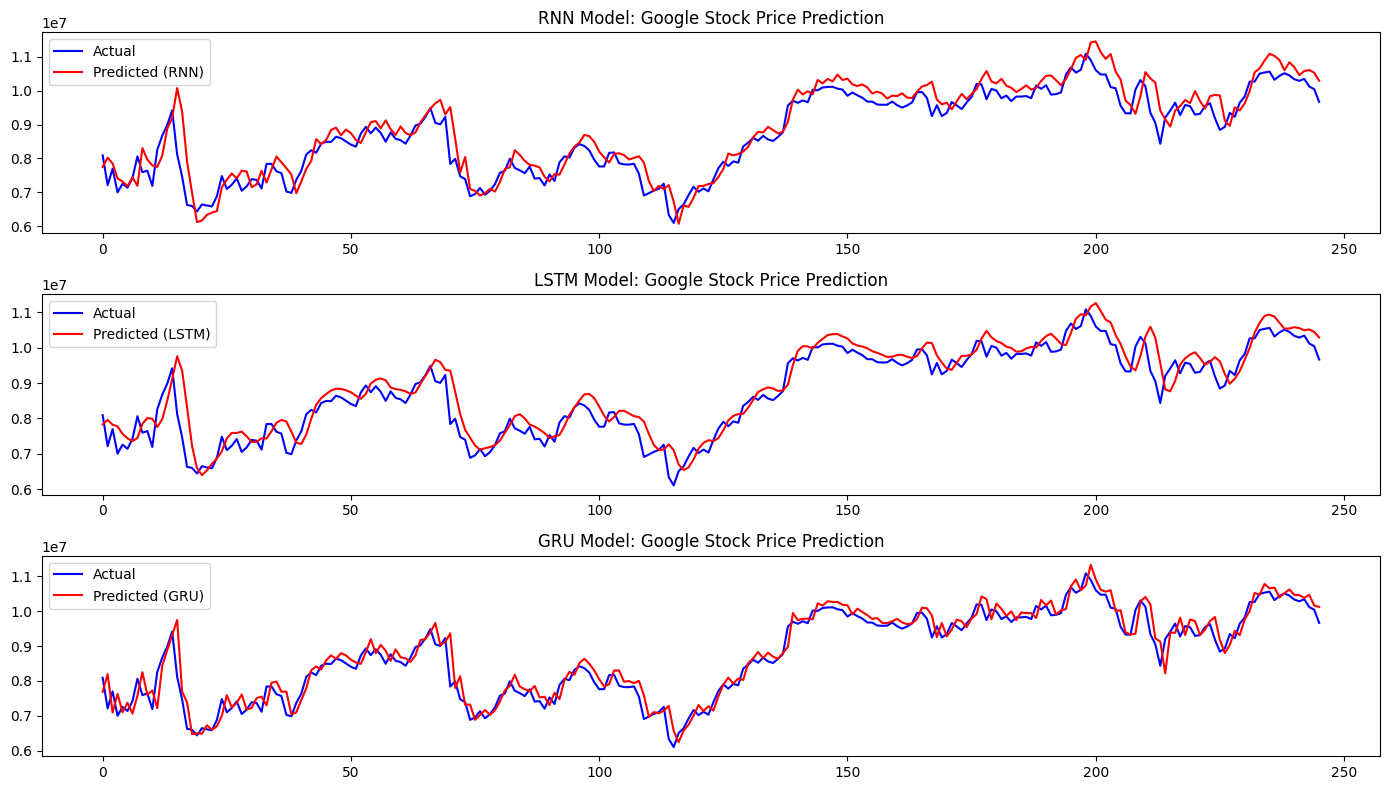

In [16]:
# Make predictions using the models
rnn_predictions = rnn_model.predict(X_val)
lstm_predictions = lstm_model.predict(X_val)
gru_predictions = gru_model.predict(X_val)

# Inverse scale the predictions and actual values
rnn_predictions = scaler.inverse_transform(np.hstack((np.zeros((rnn_predictions.shape[0], 4)), rnn_predictions)))
lstm_predictions = scaler.inverse_transform(np.hstack((np.zeros((lstm_predictions.shape[0], 4)), lstm_predictions)))
gru_predictions = scaler.inverse_transform(np.hstack((np.zeros((gru_predictions.shape[0], 4)), gru_predictions)))

y_val_actual = scaler.inverse_transform(np.hstack((np.zeros((y_val.shape[0], 4)), y_val.reshape(-1, 1))))

# Plot predictions vs actual values
plt.figure(figsize=(14, 8))

# RNN predictions
plt.subplot(3, 1, 1)
plt.plot(y_val_actual[:, 4], label='Actual', color='blue')
plt.plot(rnn_predictions[:, 4], label='Predicted (RNN)', color='red')
plt.title('RNN Model: Google Stock Price Prediction')
plt.legend()

# LSTM predictions
plt.subplot(3, 1, 2)
plt.plot(y_val_actual[:, 4], label='Actual', color='blue')
plt.plot(lstm_predictions[:, 4], label='Predicted (LSTM)', color='red')
plt.title('LSTM Model: Google Stock Price Prediction')
plt.legend()

# GRU predictions
plt.subplot(3, 1, 3)
plt.plot(y_val_actual[:, 4], label='Actual', color='blue')
plt.plot(gru_predictions[:, 4], label='Predicted (GRU)', color='red')
plt.title('GRU Model: Google Stock Price Prediction')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Calculate MAE and RMSE for each model
def evaluate_model(predictions, actual):
    mae = mean_absolute_error(actual[:, 4], predictions[:, 4])
    rmse = math.sqrt(mean_squared_error(actual[:, 4], predictions[:, 4]))
    return mae, rmse

rnn_mae, rnn_rmse = evaluate_model(rnn_predictions, y_val_actual)
lstm_mae, lstm_rmse = evaluate_model(lstm_predictions, y_val_actual)
gru_mae, gru_rmse = evaluate_model(gru_predictions, y_val_actual)

print(f'RNN MAE: {rnn_mae}, RMSE: {rnn_rmse}')
print(f'LSTM MAE: {lstm_mae}, RMSE: {lstm_rmse}')
print(f'GRU MAE: {gru_mae}, RMSE: {gru_rmse}')

RNN MAE: 342480.3174497113, RMSE: 446122.985330205
LSTM MAE: 330516.8490881895, RMSE: 435232.9300146805
GRU MAE: 245705.54113375468, RMSE: 338436.42353061325


In [ ]:
# 加载测试数据
test_df = pd.read_csv('/Users/kun/Desktop/DPF_A3/archive/Google_Stock_Price_Test.csv')

# 选择特征列和目标列
test_df['Volume'] = test_df['Volume'].str.replace(',', '')
test_df[['Open', 'High', 'Low', 'Close', 'Volume']] = test_df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
test_df['Date'] = pd.to_datetime(df['Date'])
test_features = test_df[['Open', 'High', 'Low', 'Close', 'Volume']].values

In [46]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    20 non-null     datetime64[ns]
 1   Open    20 non-null     float64       
 2   High    20 non-null     float64       
 3   Low     20 non-null     float64       
 4   Close   20 non-null     float64       
 5   Volume  20 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.1 KB


In [45]:
test_df.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-03,778.81,789.63,775.80,786.14,1657300.0
1,2012-01-04,788.36,791.34,783.16,786.90,1073000.0
2,2012-01-05,786.08,794.48,785.02,794.02,1335200.0
3,2012-01-06,795.26,807.90,792.20,806.15,1640200.0
4,2012-01-09,806.40,809.97,802.83,806.65,1272400.0


In [40]:
# 对测试数据进行标准化，使用训练时的scaler
test_scaled_features = scaler.transform(test_features)

# 创建测试数据集：使用过去30天的数据来预测接下来的一天的价格
def create_test_dataset(data, time_step=10):
    X = []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])  # 使用过去`time_step`天的数据
    return np.array(X)

# 创建测试数据集
X_test = create_test_dataset(test_scaled_features)

In [41]:
print(X_test.shape)  # 输出X_test的形状，确保它是三维的

(10, 10, 5)


In [ ]:
# 调整数据形状以适应RNN/LSTM/GRU的输入要求
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [ ]:
# 使用模型进行预测（例如使用LSTM模型）
predictions = lstm_model.predict(X_test)

# 反向标准化：将预测结果恢复到原始的尺度（即股票价格的原始单位）
predicted_prices = scaler.inverse_transform(np.hstack((np.zeros((predictions.shape[0], 4)), predictions)))

# 提取预测的关闭价格（第5列）
predicted_close_prices = predicted_prices[:, 4]

# 显示预测结果
print(predicted_close_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
[10500635.32837629 10468194.98755932 10394515.31090736 10435139.2231226
 10765454.27002907 11118659.05710459 11547475.37055016 11761991.80313349
 11516673.67883921 10713693.94370317]


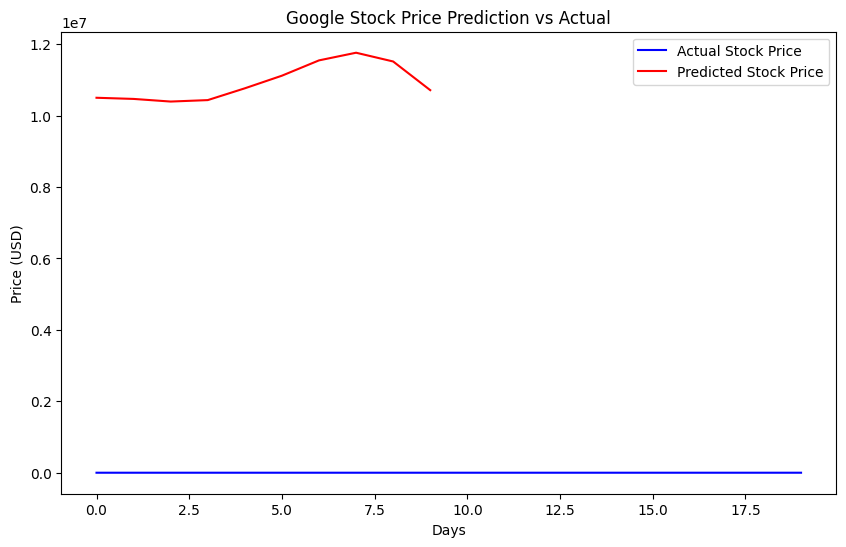

In [47]:
# 如果有实际的股价数据，反向标准化测试集的真实值
# 这里只是假设的情况，实际上你可能需要从test.csv中获取真实的'Close'值
test_actual_prices = test_df['Close'].values

# 可视化预测结果与实际结果的对比
plt.figure(figsize=(10, 6))
plt.plot(test_actual_prices, label='Actual Stock Price', color='blue')
plt.plot(predicted_close_prices, label='Predicted Stock Price', color='red')
plt.title('Google Stock Price Prediction vs Actual')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()